## 轉換資料型態

# 固定亂數

In [1]:
import torch
import numpy as np
import random

def set_seeds(seed):
    random.seed(seed)  # 設定 Python 標準庫的亂數生成器種子
    np.random.seed(seed)  # 設定 NumPy 亂數生成器種子
    torch.manual_seed(seed)  # 設定 PyTorch 的 CPU 亂數生成器種子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 設定 PyTorch 在單個 GPU 上的亂數種子
        torch.cuda.manual_seed_all(seed)  # 設定 PyTorch 在所有 GPU 上的亂數種子
    torch.backends.cudnn.benchmark = False  # 禁用 cuDNN 的基準測試功能
    torch.backends.cudnn.deterministic = True  # 強制 cuDNN 使用確定性算法

set_seeds(2526)

## 重新讀取CSV檔案

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('translate.csv')
input_texts = df['chinese'].values
target_texts = df['english'].values

x_train, x_val, y_train, y_val = train_test_split(input_texts, target_texts, train_size=0.8, random_state=46)

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
tokenizer.pad_token = tokenizer.eos_token  # 避免 padding 出錯
tokenizer.padding_side='left'

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from torch.utils.data import Dataset, DataLoader

# ---------- 自訂 Dataset 類別 ----------
class GPT2TranslateDataset(Dataset):
    def __init__(self, sources, targets, tokenizer, prompt="Translate Chinese to English: {} =>"):
        self.sources = sources
        self.targets = targets
        self.tokenizer = tokenizer
        self.prompt = prompt

    def __len__(self):
        return len(self.sources)

    def __getitem__(self, idx):
        return self.sources[idx], self.targets[idx]

    def collate_fn(self, batch):
        sources, targets = zip(*batch)
        texts = [self.prompt.format(src) + tgt + self.tokenizer.eos_token for src, tgt in zip(sources, targets)]

        tokenized = self.tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')

        input_ids = tokenized['input_ids']
        attention_mask = tokenized['attention_mask']

        labels = input_ids.clone()
        labels[attention_mask == 0] = -100

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }
    
    def better_collate_fn(self, batch):
        
        sources, targets = zip(*batch)
        prompts = [self.prompt.format(src) for src in sources]
        targets = [tgt + self.tokenizer.eos_token for tgt in targets]

        # Tokenize
        source_tokens = self.tokenizer(prompts, padding=True, truncation=True, max_length=256, add_special_tokens=False, return_tensors='pt')
        target_tokens = self.tokenizer(targets, padding=True, truncation=True, max_length=256, add_special_tokens=False, return_tensors='pt')

        src_input_ids = source_tokens["input_ids"]
        tgt_input_ids = target_tokens["input_ids"]
        tgt_attention_mask = target_tokens["attention_mask"]

        input_ids = torch.cat((src_input_ids, tgt_input_ids), dim=1)
        attention_mask = torch.cat((source_tokens["attention_mask"], tgt_attention_mask), dim=1)

        src_label_mask = torch.full_like(src_input_ids, -100)
        tgt_label_mask = tgt_input_ids.clone()
        tgt_label_mask[tgt_attention_mask == 0] = -100  # Mask padding in target

        labels = torch.cat((src_label_mask, tgt_label_mask), dim=1)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }



prompt_template="Translate Chinese to English: {} =>"
trainset = GPT2TranslateDataset(x_train, y_train, tokenizer, prompt_template)
validset = GPT2TranslateDataset(x_val, y_val, tokenizer, prompt_template)

train_loader = DataLoader(
    trainset,
    batch_size = 16,
    shuffle = True,
    num_workers = 0,
    pin_memory = True,
    collate_fn = trainset.collate_fn
)

valid_loader = DataLoader(
    validset,
    batch_size = 16,
    shuffle = False,
    num_workers = 0,
    pin_memory = True,
    collate_fn = validset.collate_fn
)

Using device: cuda


Valid Epoch 0: 100%|██████████| 374/374 [00:06<00:00, 57.72it/s, loss=1.606]


Saving Model With Loss 1.57307
Train Loss: 1.94642| Valid Loss: 1.57307| Best Loss: 1.57307



Valid Epoch 1: 100%|██████████| 374/374 [00:06<00:00, 57.52it/s, loss=1.508]


Saving Model With Loss 1.42214
Train Loss: 1.39154| Valid Loss: 1.42214| Best Loss: 1.42214



Valid Epoch 2: 100%|██████████| 374/374 [00:06<00:00, 59.31it/s, loss=1.416]


Saving Model With Loss 1.38800
Train Loss: 1.18496| Valid Loss: 1.38800| Best Loss: 1.38800



Valid Epoch 3: 100%|██████████| 374/374 [00:06<00:00, 59.37it/s, loss=1.466]


Saving Model With Loss 1.37357
Train Loss: 1.05433| Valid Loss: 1.37357| Best Loss: 1.37357



Valid Epoch 4: 100%|██████████| 374/374 [00:06<00:00, 58.71it/s, loss=1.496]


Train Loss: 0.95323| Valid Loss: 1.37401| Best Loss: 1.37357



Valid Epoch 5: 100%|██████████| 374/374 [00:06<00:00, 58.84it/s, loss=1.476]


Train Loss: 0.87118| Valid Loss: 1.38900| Best Loss: 1.37357

------------------------------------
|Model can't improve, stop training|
------------------------------------


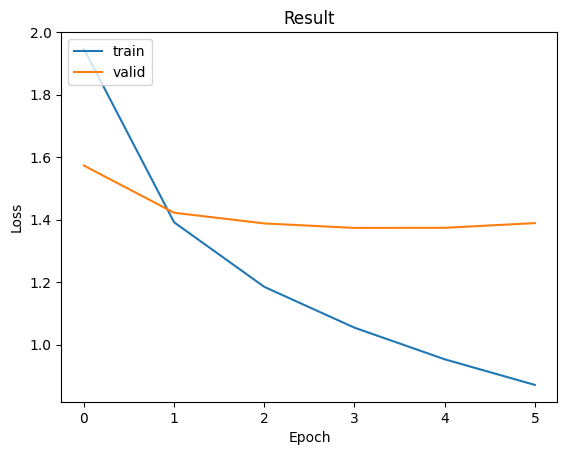

Best model loaded from ./checkpoints\best_model.ckpt


In [5]:
from Trainer import Trainer
import torch.optim as optim
from transformers import get_cosine_schedule_with_warmup

# 總步數 = epoch 數 * 每個 epoch 的 batch 數
num_training_steps = len(train_loader) * 100  # 100 是總 epoch 數
num_warmup_steps = int(0.2 * len(train_loader))  # 可調整 warmup 比例

optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)
trainer = Trainer(
    epochs=100,
    train_loader=train_loader,
    valid_loader=valid_loader,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    early_stopping=2,
    load_best_model=True,
    grad_clip=1.0,
)

trainer.train(show_loss=True)

In [ ]:
import torch
import sacrebleu
from tqdm import tqdm

def translate_and_show_results(model, tokenizer, x_valid_input, y_valid, batch_size, prompt_template):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    all_hyps = []
    all_refs = []

    for i in tqdm(range(0, len(x_valid_input), batch_size), desc="Translating"):
        batch_inputs = x_valid_input[i:i+batch_size]
        batch_labels = y_valid[i:i+batch_size]

        prompts = [prompt_template.format(src) for src in batch_inputs]

        inputs = tokenizer(
            prompts,
            max_length=256,
            truncation=True,
            padding='longest',
            return_tensors='pt'
        )

        inputs = {k: v.to(device) for k, v in inputs.items()}
        generated_ids = model.generate(
            **inputs,
            max_length=256,
            num_beams=5,  
            early_stopping=True,
            pad_token_id=tokenizer.eos_token_id
        )

        translated = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        for j, text in enumerate(translated):
            text = text.split('=>')[1].strip()
            label = str(batch_labels[j]).strip()
            all_hyps.append(text)
            all_refs.append(label)

    bleu = sacrebleu.corpus_bleu(all_hyps, [all_refs], lowercase=True)
    print(f"Corpus BLEU: {bleu.score:.2f}")

prompt_template = "Translate Chinese to English: {} =>"
translate_and_show_results(model, tokenizer, x_val, y_val, batch_size=8, prompt_template=prompt_template)

Translating: 100%|██████████| 748/748 [02:57<00:00,  4.21it/s]


Corpus BLEU: 28.62


: 